# Intro

In [1]:
from plxscripting.easy import *
password = "nicFgr^TtsFm~h~M"
localhostport_input = 10000 
localhostport_output = 10001
s_i, g_i = new_server('localhost', localhostport_input, password=password) 
s_o, g_o = new_server('localhost', localhostport_output, password=password)

In [2]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import numbers
import numpy as np
import pandas as pd

In [3]:
def get_geometry(B, D, fill_angle):
    geo = {}
    geo['points'] = ['B1', 'B2', 'B3', 'F1', 'F2', 'S1', 'S2', 'S3']
    geo['B1'] = np.array([0, D + 3 * B])
    geo['B2'] = np.array([0, 3 * B])
    geo['B3'] = np.array([B/2, 3 * B])
    geo['F1'] = np.array([B/2 + 0.5 + D / np.tan(np.radians(fill_angle)), 3 * B + D])
    geo['F2'] = np.array([B/2 + 0.5, 3 * B])
    geo['S1'] = np.array([B/2 + 2 * 0.5 + D / np.tan(np.radians(fill_angle)) + 0.5 * B, 3 * B + D])
    geo['S2'] = np.array([B/2 + 2 * 0.5 + D / np.tan(np.radians(fill_angle)) + 0.5 * B, 0])
    geo['S3'] = np.array([0, 0])
    
    geo['footing'] = np.array([geo['B1'], geo['B2'], geo['B3']])
    geo['fill'] = np.array([geo['B1'], geo['F1'], geo['F2'], geo['B2']])
    geo['soil'] = np.array([geo['S3'], geo['B2'], geo['F2'], geo['F1'], geo['S1'], geo['S2'], geo['S3']])
    
    
    point_coords = np.array([geo[point] for point in geo['points']])
    geo['xmin'] = 0 
    geo['xmax'] = np.max(point_coords[:, 0])
    geo['ymin'] = 0
    geo['ymax'] = np.max(point_coords[:, 1])
    return geo

def plot_geometry(geo):
    fig, ax = plt.subplots(1, 1, figsize=(6,6 * geo['ymax']/geo['xmax']))

    patches = [] 
    patches.append(Polygon(geo['fill'], True))
    patches.append(Polygon(geo['soil'], True))

    p = PatchCollection(patches, alpha=.4, facecolor=['greenyellow','tan'], lw=0)
    ax.add_collection(p)

    ax.plot(geo['fill'][:, 0], geo['fill'][:, 1],'-k', lw=1)
    ax.plot(geo['soil'][:, 0], geo['soil'][:, 1],'-k', lw=1)
    ax.plot(geo['footing'][:, 0], geo['footing'][:, 1],'-', color='grey', lw=10)

    point_coords = np.array([geo[i] for i in geo['points']])

    ax.set_xlim([0, 1.2 * geo['xmax']])
    ax.set_ylim([0, 1.2 * geo['ymax']])
    ax.grid(alpha=0.4)
    plt.close(fig)
    return fig

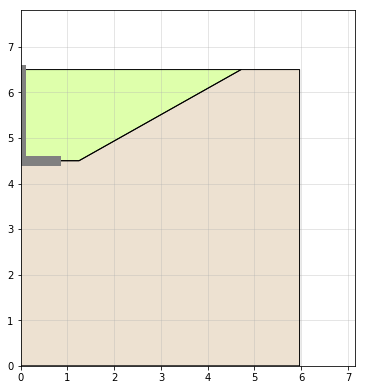

In [4]:
geo = get_geometry(1.5, 2, 30)
plot_geometry(geo)

In [5]:
def set_prop(title, comments):
    g_i.setproperties("Title",title, "Comments",comments, "ModelType","Axisymmetry" )

In [6]:
def build_materials(mdl, material):
    g_i.gotosoil()

    mdl['sand'] = g_i.soilmat("MaterialName","sand", "MaterialNumber", 0, "SoilModel", 3, "DrainageType", 0,
                             'gammaSat', material['sand']['gamma_sat'], 'gammaUnsat',material['sand']['gamma_unsat'],
                             'einit', material['sand']['e0'], 'E50ref', material['sand']['E50ref'],
                             'EoedRef', material['sand']['Eoedref'], 'EurRef', material['sand']['Euref'],
                             'powerm', material['sand']['powerm'], 'cref', material['sand']['c'],
                             'phi', material['sand']['phi'], 'psi', material['sand']['psi'],
                             'nu', material['sand']['nu'], 'K0nc',material['sand']['K0nc'],
                             'perm_primary_horizontal_axis', material['sand']['kx'],
                             'perm_vertical_axis', material['sand']['ky'],
                             'Rinter', material['sand']['Rinter'])

    mdl['fill'] = g_i.soilmat("MaterialName","fill", "MaterialNumber", 1, "SoilModel", 3, "DrainageType", 0,
                              'gammaSat', material['fill']['gamma_sat'], 'gammaUnsat',material['fill']['gamma_unsat'],
                              'einit', material['fill']['e0'], 'E50ref', material['fill']['E50ref'],
                              'EoedRef', material['fill']['Eoedref'], 'EurRef', material['fill']['Euref'],
                              'powerm', material['fill']['powerm'], 'cref', material['fill']['c'],
                              'phi', material['fill']['phi'], 'psi', material['fill']['psi'],
                              'nu', material['fill']['nu'], 'K0nc',material['fill']['K0nc'],
                              'perm_primary_horizontal_axis', material['fill']['kx'],
                              'perm_vertical_axis', material['fill']['ky'],
                              'Rinter', material['fill']['Rinter'])
    
    mdl['chimney'] = g_i.platemat("MaterialName", "chimney", "MaterialNumber", 0,
                                  "Elasticity", 0, "IsIsotropic", True,
                                  "EA", material['chimney']['EA'],
                                  "EA2", material['chimney']['EA'],
                                  "EI", material['chimney']['EI'],
                                  "nu", material['chimney']['nu'],
                                   "d", material['chimney']['d'],
                                  "Gref", material['chimney']['Gref'])
    
    mdl['footing'] = g_i.platemat("MaterialName", "footing", "MaterialNumber", 0,
                                  "Elasticity", 0, "IsIsotropic", True,
                                  "EA", material['footing']['EA'],
                                  "EA2", material['footing']['EA'],
                                  "EI", material['footing']['EI'],
                                  "nu", material['footing']['nu'],
                                   "d", material['footing']['d'],
                                  "Gref", material['footing']['Gref'])
    return mdl

def del_materials(mdl):
    g_i.gotosoil()
    g_i.delete(mdl['chimney'])
    g_i.delete(mdl['footing'])
    g_i.delete(mdl['sand'])
    g_i.delete(mdl['fill'])

In [7]:
def build_geometry(mdl, geo):
    g_i.gotostructures()
    out = g_i.polygon(list(geo['B1']), list(geo['B2']), list(geo['F2']), list(geo['F1']))
    mdl['polygon_fill'] = out[0]
    mdl['soil_fill'] = out[1]
    out = g_i.polygon(list(geo['B2']), list(geo['F2']), list(geo['F1']),
                      list(geo['S1']), list(geo['S2']), list(geo['S3']))
    mdl['polygon_sand'] = out[0]
    mdl['soil_sand'] = out[1]
    
    out = g_i.plate(list(geo['B1']), list(geo['B2']), list(geo['B3']))
    mdl['B1_plate'] = out[0]
    mdl['B2_plate'] = out[1]
    mdl['B3_plate'] = out[2]
    mdl['lineB1B2_plate'] = out[3]
    mdl['lineB2B3_plate'] = out[4]
    mdl['plateB1B2'] = out[5]
    mdl['plateB2B3'] = out[6]

    out = g_i.posinterface(list(geo['B1']), list(geo['B2']), list(geo['B3']))
    mdl['B1_interface'] = out[0]
    mdl['B2_interface'] = out[1]
    mdl['B3_interface'] = out[2]
    mdl['lineB1B2_interface'] = out[3]
    mdl['lineB2B3_interface'] = out[4]
    mdl['interfaceB1B2_interface'] = out[5]
    mdl['interfaceB2B3_interface'] = out[6]
    
    mdl['B1_point'], mdl['B1_load'] = g_i.pointload(list(geo['B1']))
    return mdl

def del_geometry(mdl):
    g_i.gotostructures()
    g_i.delete(mdl['polygon_fill'])
    g_i.delete(mdl['polygon_sand'])
    g_i.delete(mdl['B3_interface'])
    g_i.delete(mdl['B2_interface'])
    g_i.delete(mdl['B1_interface'])
    g_i.delete(mdl['B3_plate'])
    g_i.delete(mdl['B2_plate'])
    g_i.delete(mdl['B1_plate'])
    g_i.delete(mdl['B1_point'])

In [8]:
def set_load_test(g_i, mdl, testid, start_phase_id, loads):
    if 'test ids' not in mdl.keys():
        mdl['test ids'] = {}
    if testid in mdl['test ids'].keys():
        print('Duplicated test id')
        return
    mdl['test ids'][testid] = []
    if isinstance(loads, numbers.Number):
        loads = [loads]
    phaseids = [testid + '_stage_{:.0f}'.format(idx) for idx in range(len(loads))]
    previous_phase = [start_phase_id] + phaseids[:-1]
    for load, pidx, previdx in zip(loads, phaseids, previous_phase):
        mdl['test ids'][testid].append(pidx)
        mdl['iphases'][pidx] = g_i.phase(mdl['iphases'][previdx])
        mdl['iphases'][pidx].Identification = pidx
        g_i.Model.CurrentPhase = mdl['iphases'][pidx]
        g_i.activate(mdl['B1_point'], g_i.Model.CurrentPhase)
        g_i.set(g_i.PointLoad_1_1.Fy, g_i.Model.CurrentPhase, load)

In [9]:
def build_phases(mdl):
    mdl['iphases'] = {}
    g_i.gotostages()
    
    mdl['iphases']['Initial phase'] = g_i.InitialPhase
    g_i.Model.CurrentPhase = g_i.InitialPhase
    g_i.activate(mdl['polygon_sand'], g_i.Model.CurrentPhase)
    g_i.activate(mdl['polygon_fill'], g_i.Model.CurrentPhase)
    g_i.deactivate(mdl['lineB1B2_plate'], g_i.Model.CurrentPhase)
    g_i.deactivate(mdl['lineB2B3_plate'], g_i.Model.CurrentPhase)
    g_i.set(g_i.Plate_1_1.Material, g_i.Model.CurrentPhase, mdl['chimney'])
    g_i.set(g_i.Plate_2_1.Material, g_i.Model.CurrentPhase, mdl['footing'])

    g_i.set(g_i.Soil_2_1.Material, g_i.Model.CurrentPhase, mdl['sand'])
    g_i.set(g_i.Soil_1_1.Material, g_i.Model.CurrentPhase, mdl['sand'])

    g_i.set(g_i.PointLoad_1_1.Fy, g_i.Model.CurrentPhase, 0)
    
    mdl['iphases']['excavation'] = g_i.phase(g_i.InitialPhase)
    mdl['iphases']['excavation'].Identification = "excavation"
    g_i.Model.CurrentPhase = mdl['iphases']['excavation']
    g_i.deactivate(mdl['polygon_fill'], g_i.Model.CurrentPhase)

    mdl['iphases']['construction'] = g_i.phase(mdl['iphases']['excavation'])
    mdl['iphases']['construction'].Identification = "construction"
    g_i.Model.CurrentPhase = mdl['iphases']['construction']
    g_i.activate(mdl['polygon_fill'], g_i.Model.CurrentPhase)
    g_i.activate(mdl['lineB1B2_plate'], g_i.Model.CurrentPhase)
    g_i.activate(mdl['lineB2B3_plate'], g_i.Model.CurrentPhase)

    g_i.set(g_i.Soil_2_1.Material, g_i.Model.CurrentPhase, mdl['fill'])

    '''
    mdl['iphases']['loading'] = g_i.phase(mdl['iphases']['construction'])
    mdl['iphases']['loading'].Identification = "loading"
    g_i.Model.CurrentPhase = mdl['iphases']['loading']
    g_i.activate(mdl['B1_point'], g_i.Model.CurrentPhase)
    g_i.set(g_i.PointLoad_1_1.Fy, g_i.Model.CurrentPhase, -100)
    
    mdl['iphases']['pullout'] = g_i.phase(mdl['iphases']['loading'])
    mdl['iphases']['pullout'].Identification = "pullout"
    g_i.Model.CurrentPhase = mdl['iphases']['pullout']
    g_i.set(g_i.PointLoad_1_1.Fy, g_i.Model.CurrentPhase, 20)
    '''
    return mdl

def del_phases(mdl):
    g_i.gotostages()
    if 'ophases' in mdl.keys():
        _ = mdl.pop('ophases')
    if 'iphases' not in mdl.keys():
        return
    for phase_id in list(mdl['iphases'].keys())[::-1][:-1]:
        g_i.delete(mdl['iphases'][phase_id])
    _ = mdl.pop('iphases')
    if 'test ids' in mdl.keys():
        _ = mdl.pop('test ids')
    g_i.Model.CurrentPhase = g_i.InitialPhase
    g_i.deactivate(mdl['polygon_sand'], g_i.Model.CurrentPhase)
    g_i.deactivate(mdl['polygon_fill'], g_i.Model.CurrentPhase)

In [10]:
def select_points(geo):
    g_i.selectmeshpoints()
    g_o.addcurvepoint("node",[0, geo['ymax']])
    g_o.update()

In [11]:
def build_model(title, comments, B, D, fill_angle, mesh_density, material):
    mdl = {}
    geo = get_geometry(B, D, fill_angle)
    fig = plot_geometry(geo)
    set_prop(title, comments)
    mdl = build_geometry(mdl, geo)
    mdl = build_materials(mdl, material)
    g_i.gotomesh()
    mesh = g_i.mesh(mesh_density)
    mdl = build_phases(mdl)
    select_points(geo)  
    return mdl, fig

In [12]:
def get_results(mdl, g_i, g_o):
    # open output
    g_i.view(g_i.Phases[0])
    # create dictionary with output phases with the same name that input phases
    mdl['ophases'] = {}
    for phase in g_o.phases:
        internal_id = phase.Name.value
        user_given_id = phase.Identification.value
        user_given_id =  user_given_id[:-(len(internal_id) + 3)]
        mdl['ophases'][user_given_id] = phase
    
    # retrieve data
    phases = list(mdl['iphases'].keys())
    phases.remove('Initial phase')
    phases.remove('excavation')
    mdl['results'] = {}
    for phaseid in phases:
        previous_iphase = mdl['iphases'][phaseid].PreviousPhase
        current_iphase = mdl['iphases'][phaseid]
        current_ophase = mdl['ophases'][phaseid]
        Uy = []
        Fy = []
        sumMstage = []
        load_start = 0
        load_end = 0
        if g_i.PointLoad_1_1.Active[previous_iphase] is not None:
            if g_i.PointLoad_1_1.Active[previous_iphase].value:
                load_start = g_i.PointLoad_1_1.Fy[current_iphase].value
        if g_i.PointLoad_1_1.Active[current_iphase] is not None:
            if g_i.PointLoad_1_1.Active[current_iphase].value:
                load_end = g_i.PointLoad_1_1.Fy[current_iphase].value

        for step in current_ophase.Steps.value:
            Uy.append(g_o.getcurveresults(g_o.Nodes[0], step, g_o.ResultTypes.Plate.Uy))
            sumMstage.append(step.Reached.SumMstage.value)
        Fy = np.zeros_like(Uy)
        sumMstage = np.array(sumMstage)

        if g_i.PointLoad_1_1.Active[current_iphase].value:

            Fy = load_start + (load_end - load_start) * sumMstage

        mdl['results'][phaseid] = {}
        mdl['results'][phaseid]['load start'] = [load_start] * len(Uy)
        mdl['results'][phaseid]['load end'] = [load_end] * len(Uy)
        mdl['results'][phaseid]['uy'] = Uy
        mdl['results'][phaseid]['fy'] = Fy
        mdl['results'][phaseid]['sumMstage'] = sumMstage
    # build df
    results_df = pd.DataFrame()
    for phaseid in mdl['results']:
        df = pd.DataFrame(mdl['results'][phaseid])
        df['phase'] = phaseid
        df['plx id'] = mdl['iphases'][phaseid].Name.value
        df['previous plx id'] = mdl['iphases'][phaseid].PreviousPhase.Name.value
        df['previous'] = mdl['iphases'][phaseid].Identification.value
        results_df = pd.concat([results_df, df])
    
    results_df.loc[results_df['phase']=='construction','test'] = 'construction'
    for tid in mdl['test ids']:
        for stage in mdl['test ids'][tid]:
            results_df.loc[results_df['phase']==stage,'test'] = tid
    return results_df

In [13]:
def plot_test(results_df, testid, figsize=(7, 5), offset_construction=True):
    construction_disp = 0
    if offset_construction:
        construction_disp = results_df.loc[results_df['phase']=='construction', 'uy'].min()
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    idx = results_df['test']==testid
    for sidx, stage in enumerate(results_df.loc[idx, 'phase'].unique()):
        idx2 = (idx) & (results_df['phase']==stage)
        uy = results_df.loc[idx2,'uy'].to_numpy() - construction_disp
        fy = results_df.loc[idx2,'fy'].to_numpy()
        ax.plot(-uy, -fy,label='phase {:.0f}'.format(sidx))
    ax.grid(alpha=0.2)
    ax.set_xlabel('Vertical displacement [m]')
    ax.set_ylabel('Vertical force [kN]')
    ax.legend()
    plt.close(fig)
    return fig    

In [14]:
def plot_test_compare(results_df, test_id, figsize=(7, 5), offset_construction=True):
    construction_disp = 0
    if offset_construction:
        construction_disp = results_df.loc[results_df['phase']=='construction', 'uy'].min()
    if isinstance(test_id, str):
        test_id = [test_id]
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    for tid in test_id:
        idx = results_df['test']==tid
        uy = results_df.loc[idx,'uy'].to_numpy() - construction_disp
        fy = results_df.loc[idx,'fy'].to_numpy()
        ax.plot(-uy, -fy,label=tid)
    ax.grid(alpha=0.2)
    ax.set_xlabel('Vertical displacement [m]')
    ax.set_ylabel('Vertical force [kN]')
    ax.legend()
    plt.close(fig)
    return fig  

In [15]:
title = "Embedded footing in sand"
comments = ""

B0 = 4000
B = 1.5
D0 = 4000
D = 2
fill_angle = 32

mesh_density = 0.06

material = {}
material['chimney'] = {}
material['chimney']['fc'] = 24 # kPa
material['chimney']['E'] = 4700 *  np.sqrt(material['chimney']['fc']) # kPa
material['chimney']['nu'] = 0.4 # 
material['chimney']['EA'] = np.pi * B0**2/4 * material['chimney']['E']
material['chimney']['EI'] = np.pi * B0**4/64 * material['chimney']['E']
material['chimney']['d'] = np.sqrt(12 * material['chimney']['EI'] / material['chimney']['EA'])
material['chimney']['Gref'] = material['chimney']['EA'] / material['chimney']['d']  / (2 * (1 + material['chimney']['nu'])) # KPa


material['chimney']['gamma'] = 24 # kN/m3

material['footing'] = {}
material['footing']['fc'] = 24 # kPa
material['footing']['E'] = 4700 *  np.sqrt(material['footing']['fc']) # kPa
material['footing']['nu'] = 0.4 #
material['footing']['EA'] = np.pi * B0**2/4 * material['footing']['E']
material['footing']['EI'] = np.pi * B0**4/64 * material['footing']['E']
material['footing']['d'] = np.sqrt(12 * material['footing']['EI'] / material['footing']['EA'])
material['footing']['Gref'] = material['footing']['EA'] / material['footing']['d']  / (2 * (1 + material['footing']['nu'])) # KPa

material['sand'] = {}
material['sand']['gamma_unsat'] = 17
material['sand']['gamma_sat'] = 20
material['sand']['e0'] = 0.2
material['sand']['E50ref'] = 4e4
material['sand']['Eoedref'] = 4e4
material['sand']['Euref'] = 1.2e5
material['sand']['powerm'] = 0.5
material['sand']['c'] = 0
material['sand']['phi'] = 32
material['sand']['psi'] = 2
material['sand']['nu'] = 0.2
material['sand']['K0nc'] = 0.4701
material['sand']['kx'] = 1
material['sand']['ky'] =1
material['sand']['Rinter'] = 0.67

material['fill'] = {}
material['fill']['gamma_unsat'] = 17
material['fill']['gamma_sat'] = 20
material['fill']['e0'] = 0.2
material['fill']['E50ref'] = 4e4
material['fill']['Eoedref'] = 4e4
material['fill']['Euref'] = 1.2e5
material['fill']['powerm'] = 0.5
material['fill']['c'] = 0
material['fill']['phi'] = 32
material['fill']['psi'] = 2
material['fill']['nu'] = 0.2
material['fill']['K0nc'] = 0.4701
material['fill']['kx'] = 1
material['fill']['ky'] = 1
material['fill']['Rinter'] = 0.67

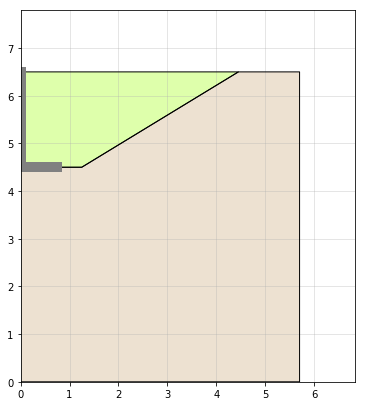

In [25]:
mdl, fig = build_model(title, comments, B, D, fill_angle, mesh_density, material)
fig

In [26]:
set_load_test(g_i, mdl, 'bearing', 'construction', -100)
#set_load_test(g_i, mdl, 'cycle', 'construction', [-20, 5, -20, 10])

g_i.calculate()
results_df = get_results(mdl, g_i, g_o)

EncryptionError: Reply code is different from what was sent! Server might be spoofed!

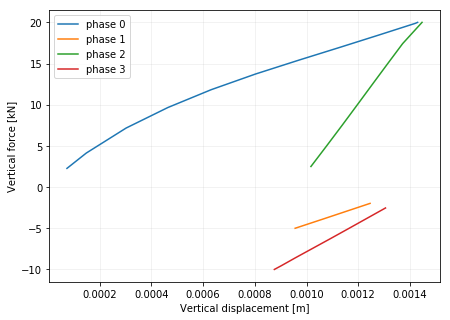

In [21]:
plot_test(results_df, 'cycle')

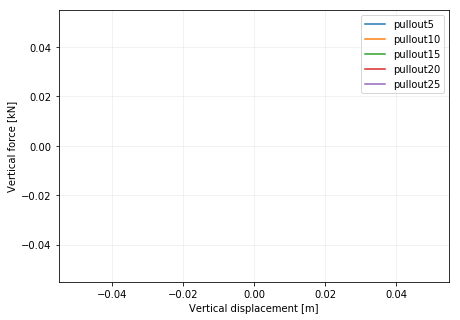

In [22]:
plot_test_compare(results_df, ['pullout5', 'pullout10', 'pullout15', 'pullout20', 'pullout25'])

In [23]:
results_df.loc[results_df['phase']=='pullout_stage_0']

,load start,load end,uy,fy,sumMstage,phase,plx id,previous plx id,previous,test


In [24]:
results_df.loc[results_df['phase']=='pullout_stage_1']

,load start,load end,uy,fy,sumMstage,phase,plx id,previous plx id,previous,test
